In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch import nn, optim

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

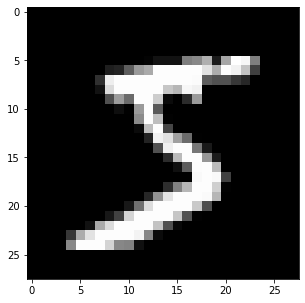

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Denoising

One of the major applications of autoencoder is to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

>**We'll use noisy images as input and the original, clean images as targets.** 

Below is an example of some of the noisy images and the associated, denoised images.

<img src='denoising.png' />

A schematic of the network is shown below.

<img src='conv_enc_3.jpg' width=640px>

Since this is a harder problem for the network, we'll want to use _deeper_ convolutional layers here; layers with more feature maps. We might also consider adding additional layers starting with a depth of 32 for the convolutional layers in the encoder, and the same depths going backward through the decoder.

In [4]:
model = nn.Sequential(nn.Conv2d(1, 32, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(32, 16, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 8, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.ConvTranspose2d(8, 8, 3, stride=2),  # kernel_size=3 to get to a 7x7 output from 3X3 image
                      nn.ReLU(),
                      nn.ConvTranspose2d(8, 16, 2, stride=2), #kernel = 2 and stride = 2 will increase spatial dims by 2
                      nn.ReLU(),
                      nn.ConvTranspose2d(16, 32, 2, stride=2),
                      nn.ReLU(),
                      nn.Conv2d(32, 1, 3, padding = 1),
                      nn.Sigmoid())

# Move the model to GPU
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (10): ReLU()
  (11): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (12): ReLU()
  (13): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (14): ReLU()
  (15): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): Sigmoid()
)

---
## Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, we'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [5]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        #Move original & noisy images to GPU
        images, noisy_imgs = images.cuda(), noisy_imgs.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.964982
Epoch: 2 	Training Loss: 0.652082
Epoch: 3 	Training Loss: 0.605917
Epoch: 4 	Training Loss: 0.574522
Epoch: 5 	Training Loss: 0.550262
Epoch: 6 	Training Loss: 0.529673
Epoch: 7 	Training Loss: 0.510650
Epoch: 8 	Training Loss: 0.487680
Epoch: 9 	Training Loss: 0.467624
Epoch: 10 	Training Loss: 0.454395
Epoch: 11 	Training Loss: 0.444517
Epoch: 12 	Training Loss: 0.438651
Epoch: 13 	Training Loss: 0.433835
Epoch: 14 	Training Loss: 0.429468
Epoch: 15 	Training Loss: 0.426356
Epoch: 16 	Training Loss: 0.423701
Epoch: 17 	Training Loss: 0.421129
Epoch: 18 	Training Loss: 0.419386
Epoch: 19 	Training Loss: 0.417185
Epoch: 20 	Training Loss: 0.415138


## Checking out the results

Let us add noise to the test images and pass them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

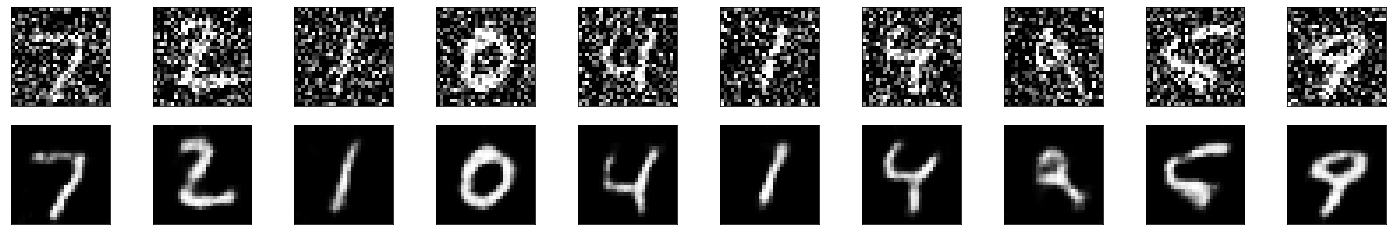

In [7]:
#Move the model back to CPU (the test images are in CPU)
model.cpu()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)